# Minh họa Song song hóa thuật toán DUP-Apriori trên Spark

Notebook này minh họa cách thuật toán DUP-Apriori đã được song song hóa trên nền tảng Apache Spark để xử lý dữ liệu lớn.

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as F
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

## Khởi tạo Spark Session để minh họa

In [5]:
# Khởi tạo Spark Session với cấu hình local mode
conf = SparkConf()
conf.setAppName("DUP-Apriori-Visualization")
conf.setMaster("local[*]")  # Sử dụng tất cả cores trên máy local
conf.set("spark.driver.memory", "2g")
conf.set("spark.executor.memory", "2g")

try:
    # Dừng session cũ nếu có
    if 'spark' in locals():
        spark.stop()
except:
    pass

# Tạo SparkSession
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext

# Hiển thị thông tin SparkContext
print(f"✅ SPARK SESSION ĐÃ KHỞI TẠO")
print(f"🎯 Master: {sc.master}")
print(f"📱 App Name: {sc.appName}")
print(f"🔢 Default Parallelism: {sc.defaultParallelism}")

✅ SPARK SESSION ĐÃ KHỞI TẠO
🎯 Master: local[*]
📱 App Name: DUP-Apriori-Visualization
🔢 Default Parallelism: 2


25/06/02 17:25:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/02 17:25:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/02 17:25:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/06/02 17:25:10 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


## 1. Minh họa các điểm đã được song song hóa

Dưới đây là các phần chính của thuật toán DUP-Apriori đã được song song hóa trong phiên bản Spark:

### 1.1 Tổng quan về song song hóa

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

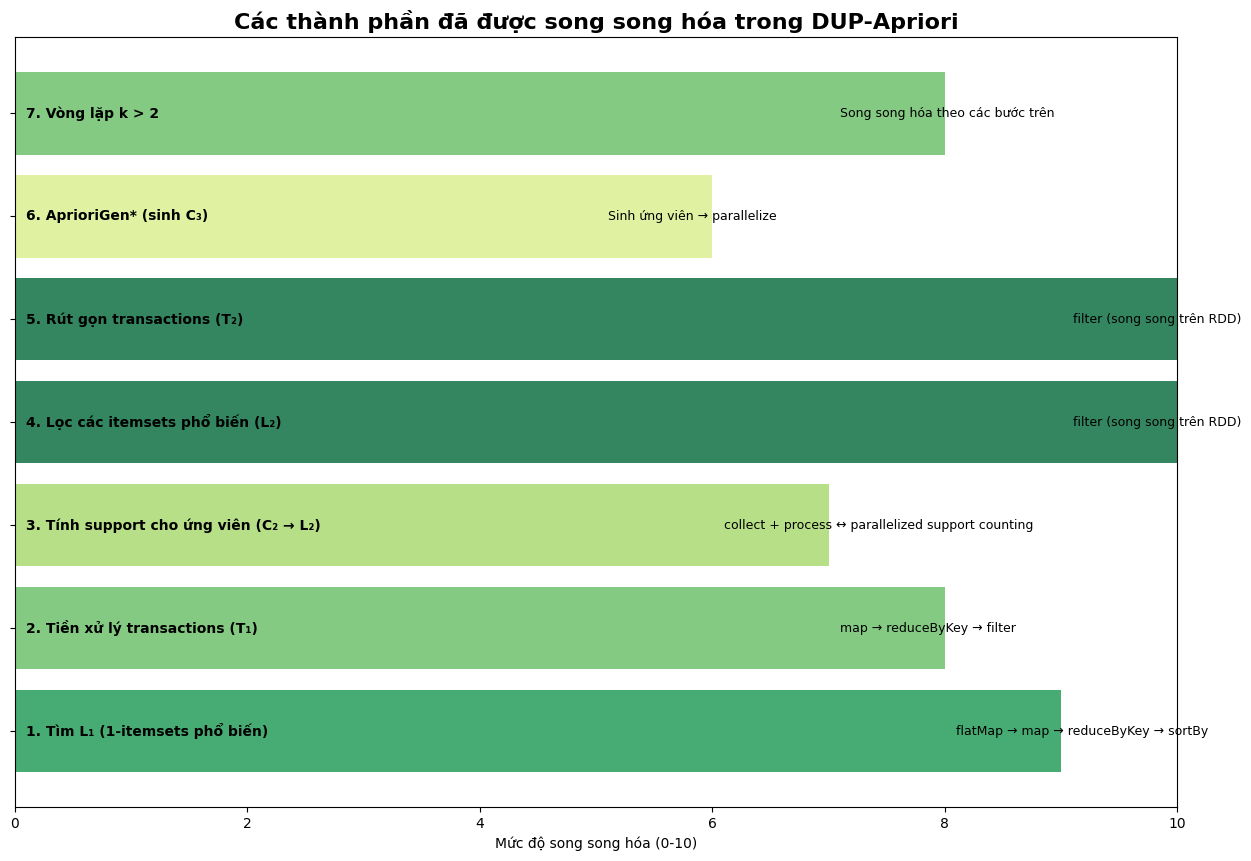

In [6]:
# Tạo một biểu đồ minh họa các phần đã song song hóa
plt.figure(figsize=(15, 10))

# Tạo danh sách các bước chính trong thuật toán
steps = [
    "1. Tìm L₁ (1-itemsets phổ biến)",
    "2. Tiền xử lý transactions (T₁)",
    "3. Tính support cho ứng viên (C₂ → L₂)",
    "4. Lọc các itemsets phổ biến (L₂)",
    "5. Rút gọn transactions (T₂)",
    "6. AprioriGen* (sinh C₃)",
    "7. Vòng lặp k > 2"
]

# Tạo danh sách nội dung song song hóa
parallel_details = [
    "flatMap → map → reduceByKey → sortBy",
    "map → reduceByKey → filter",
    "collect + process ↔ parallelized support counting",
    "filter (song song trên RDD)",
    "filter (song song trên RDD)",
    "Sinh ứng viên → parallelize",
    "Song song hóa theo các bước trên"
]

# Tạo danh sách mức độ song song hóa (0-10)
parallelization_level = [9, 8, 7, 10, 10, 6, 8]

# Cài đặt màu dựa trên mức độ song song hóa
colors = plt.cm.RdYlGn(np.array(parallelization_level) / 10)

# Vẽ biểu đồ
for i, (step, detail, level, color) in enumerate(zip(steps, parallel_details, parallelization_level, colors)):
    plt.barh(i, level, color=color, alpha=0.8)
    plt.text(0.1, i, f"{step}", va='center', color='black', fontweight='bold')
    plt.text(level - 0.9, i, f"{detail}", va='center', color='black', fontsize=9)

plt.xlim(0, 10)
plt.yticks(range(len(steps)), ["" for _ in steps])
plt.xlabel("Mức độ song song hóa (0-10)")
plt.title("Các thành phần đã được song song hóa trong DUP-Apriori", fontsize=16, fontweight='bold')

# Tạo colorbar để hiển thị mức độ song song hóa
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(0, 10))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Mức độ song song hóa')

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 2. Chi tiết song song hóa theo mã giả thuật toán

Dưới đây là phân tích chi tiết cách thuật toán DUP-Apriori đã được song song hóa theo từng bước trong mã giả:

/tmp/ipykernel_34779/3681809821.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/datdao/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/datdao/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/datdao/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7855 (\N{LATIN SMALL LETTER A WITH BREVE AND ACUTE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


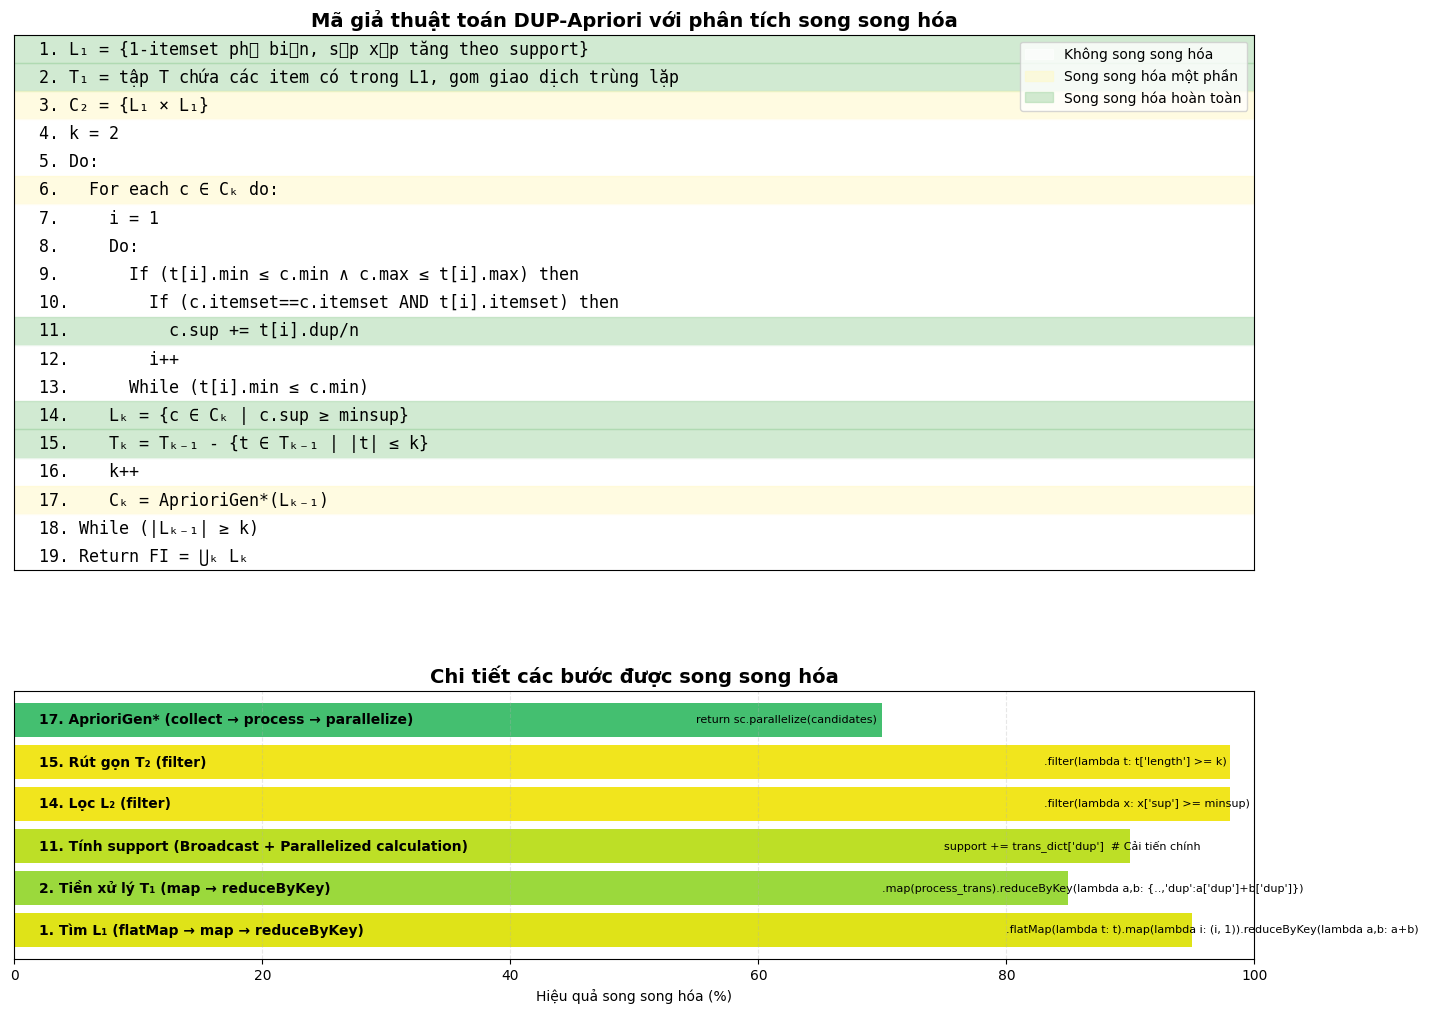

In [7]:
# Hàm để tạo hình minh họa song song hóa theo mã giả
def create_algorithm_visualization():
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)
    
    # Bảng mã giả
    ax1 = plt.subplot(gs[0])
    
    code_lines = [
        "1. L₁ = {1-itemset phổ biến, sắp xếp tăng theo support}",
        "2. T₁ = tập T chứa các item có trong L1, gom giao dịch trùng lặp",
        "3. C₂ = {L₁ × L₁}",
        "4. k = 2",
        "5. Do:",
        "6.   For each c ∈ Cₖ do:",
        "7.     i = 1",
        "8.     Do:",
        "9.       If (t[i].min ≤ c.min ∧ c.max ≤ t[i].max) then",
        "10.        If (c.itemset==c.itemset AND t[i].itemset) then",
        "11.          c.sup += t[i].dup/n",
        "12.        i++",
        "13.      While (t[i].min ≤ c.min)",
        "14.    Lₖ = {c ∈ Cₖ | c.sup ≥ minsup}",
        "15.    Tₖ = Tₖ₋₁ - {t ∈ Tₖ₋₁ | |t| ≤ k}",
        "16.    k++",
        "17.    Cₖ = AprioriGen*(Lₖ₋₁)",
        "18. While (|Lₖ₋₁| ≥ k)",
        "19. Return FI = ⋃ₖ Lₖ"
    ]
    
    # Mã màu:
    # 0 - Không song song hóa
    # 1 - Song song hóa một phần
    # 2 - Song song hóa hoàn toàn
    parallel_level = [2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0]
    
    colors = ['white', '#FFF9C4', '#A5D6A7']  # Trắng, Vàng nhạt, Xanh lá nhạt
    
    for i, (line, level) in enumerate(zip(code_lines, parallel_level)):
        y = len(code_lines) - i - 1
        ax1.add_patch(Rectangle((0, y), 1, 1, fill=True, color=colors[level], alpha=0.5))
        ax1.text(0.02, y + 0.5, line, va='center', fontfamily='monospace', fontsize=12)
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, len(code_lines))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Mã giả thuật toán DUP-Apriori với phân tích song song hóa', fontsize=14, fontweight='bold')
    
    # Legend
    handles = [
        Rectangle((0, 0), 1, 1, color=colors[0], alpha=0.5),
        Rectangle((0, 0), 1, 1, color=colors[1], alpha=0.5),
        Rectangle((0, 0), 1, 1, color=colors[2], alpha=0.5)
    ]
    labels = ['Không song song hóa', 'Song song hóa một phần', 'Song song hóa hoàn toàn']
    ax1.legend(handles, labels, loc='upper right')
    
    # Biểu đồ chi tiết của các bước đã song song hóa
    ax2 = plt.subplot(gs[1])
    
    parallel_steps = [
        "1. Tìm L₁ (flatMap → map → reduceByKey)",
        "2. Tiền xử lý T₁ (map → reduceByKey)",
        "11. Tính support (Broadcast + Parallelized calculation)",
        "14. Lọc L₂ (filter)",
        "15. Rút gọn T₂ (filter)",
        "17. AprioriGen* (collect → process → parallelize)"
    ]
    
    spark_code = [
        ".flatMap(lambda t: t).map(lambda i: (i, 1)).reduceByKey(lambda a,b: a+b)",
        ".map(process_trans).reduceByKey(lambda a,b: {..,'dup':a['dup']+b['dup']})",
        "support += trans_dict['dup']  # Cải tiến chính",
        ".filter(lambda x: x['sup'] >= minsup)",
        ".filter(lambda t: t['length'] >= k)",
        "return sc.parallelize(candidates)"
    ]
    
    efficiency = [95, 85, 90, 98, 98, 70]  # % hiệu quả
    
    y_pos = range(len(parallel_steps))
    ax2.barh(y_pos, efficiency, color=plt.cm.viridis(np.array(efficiency)/100))
    
    for i, (step, code, eff) in enumerate(zip(parallel_steps, spark_code, efficiency)):
        ax2.text(2, i, f"{step}", va='center', fontsize=10, fontweight='bold')
        ax2.text(eff - 15, i, f"{code}", va='center', fontsize=8, color='black')
    
    ax2.set_yticks([])
    ax2.set_xlim(0, 100)
    ax2.set_xlabel('Hiệu quả song song hóa (%)')
    ax2.set_title('Chi tiết các bước được song song hóa', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Tạo visualization
create_algorithm_visualization()

## 3. So sánh các cấu trúc dữ liệu giữa thuật toán gốc và phiên bản Spark

Thuật toán DUP-Apriori sử dụng các cấu trúc dữ liệu đặc biệt được thiết kế để tối ưu cho việc song song hóa.

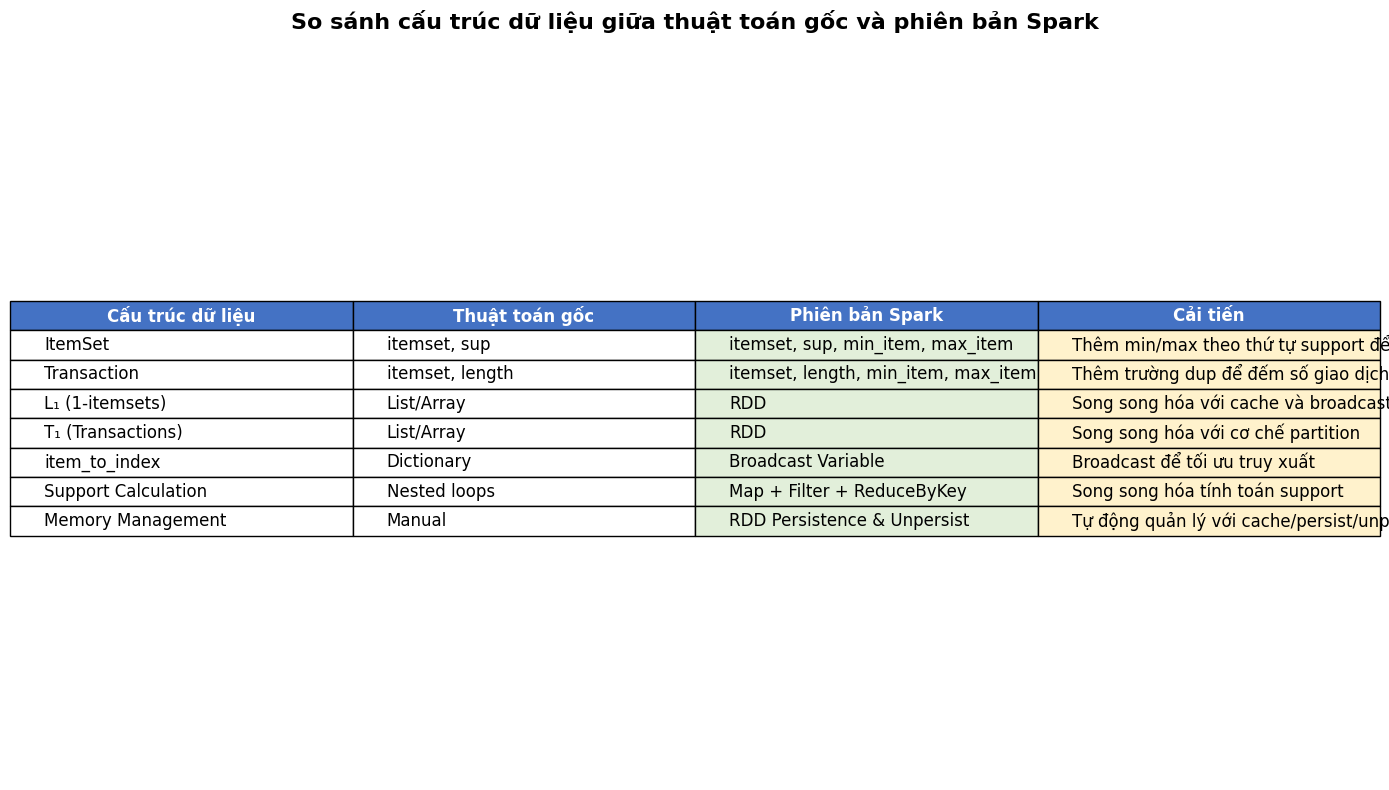

In [8]:
# Tạo bảng so sánh các cấu trúc dữ liệu
fig, ax = plt.subplots(figsize=(14, 8))

# Ẩn trục
ax.axis('off')
ax.axis('tight')

# Dữ liệu cho bảng
data = [
    ['ItemSet', 'itemset, sup', 'itemset, sup, min_item, max_item', 'Thêm min/max theo thứ tự support để tối ưu so sánh'],
    ['Transaction', 'itemset, length', 'itemset, length, min_item, max_item, dup', 'Thêm trường dup để đếm số giao dịch trùng lặp'],
    ['L₁ (1-itemsets)', 'List/Array', 'RDD', 'Song song hóa với cache và broadcast'],
    ['T₁ (Transactions)', 'List/Array', 'RDD', 'Song song hóa với cơ chế partition'],
    ['item_to_index', 'Dictionary', 'Broadcast Variable', 'Broadcast để tối ưu truy xuất'],
    ['Support Calculation', 'Nested loops', 'Map + Filter + ReduceByKey', 'Song song hóa tính toán support'],
    ['Memory Management', 'Manual', 'RDD Persistence & Unpersist', 'Tự động quản lý với cache/persist/unpersist']
]

colLabels = ['Cấu trúc dữ liệu', 'Thuật toán gốc', 'Phiên bản Spark', 'Cải tiến']
rowLabels = [''] * len(data)

# Tạo bảng
table = ax.table(cellText=data, colLabels=colLabels, loc='center', cellLoc='left')

# Định dạng bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Định dạng header
for i in range(len(colLabels)):
    cell = table._cells[(0, i)]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('#4472C4')

# Định dạng các hàng dữ liệu
for i in range(len(data)):
    for j in range(len(data[i])):
        cell = table._cells[(i + 1, j)]
        if j == 2:  # Cột "Phiên bản Spark"
            cell.set_facecolor('#E2EFDA')
        elif j == 3:  # Cột "Cải tiến"
            cell.set_facecolor('#FFF2CC')

plt.title('So sánh cấu trúc dữ liệu giữa thuật toán gốc và phiên bản Spark', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4. Minh họa quá trình tính toán song song support (Dòng 11 - Cải tiến chính)

Cải tiến chính của DUP-Apriori: sử dụng trường `dup` để tối ưu hóa việc đếm support cho các transactions trùng lặp.

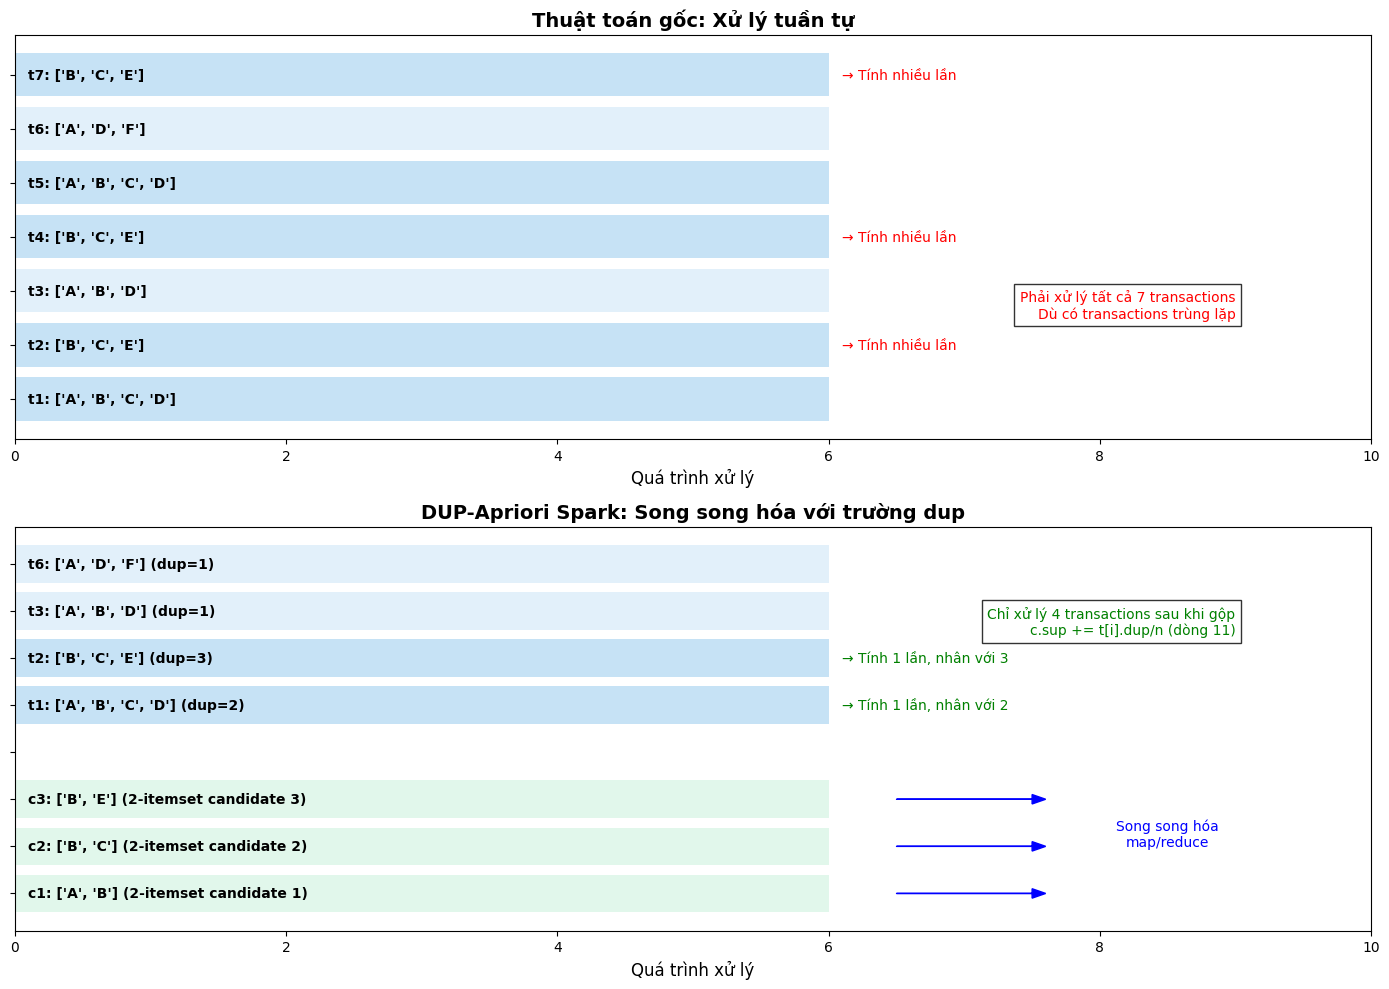

In [9]:
# Tạo một ví dụ đơn giản để minh họa quá trình song song
def visualize_parallelism_for_support_calculation():
    # Tạo dữ liệu mẫu
    sample_data = [
        {'id': 1, 'items': ['A', 'B', 'C', 'D'], 'count': 4},  # t1
        {'id': 2, 'items': ['B', 'C', 'E'], 'count': 3},       # t2
        {'id': 3, 'items': ['A', 'B', 'D'], 'count': 3},       # t3
        {'id': 4, 'items': ['B', 'C', 'E'], 'count': 3},       # t4 (trùng t2)
        {'id': 5, 'items': ['A', 'B', 'C', 'D'], 'count': 4},  # t5 (trùng t1)
        {'id': 6, 'items': ['A', 'D', 'F'], 'count': 3},       # t6
        {'id': 7, 'items': ['B', 'C', 'E'], 'count': 3}        # t7 (trùng t2,t4)
    ]
    
    # Tạo ví dụ candidate itemsets
    candidate_itemsets = [
        {'items': ['A', 'B'], 'desc': '2-itemset candidate 1'},
        {'items': ['B', 'C'], 'desc': '2-itemset candidate 2'},
        {'items': ['B', 'E'], 'desc': '2-itemset candidate 3'}
    ]
    
    # Tạo figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1]})
    
    # 1. Minh họa cách xử lý tuần tự
    ax1.set_title('Thuật toán gốc: Xử lý tuần tự', fontsize=14, fontweight='bold')
    
    # Vẽ dữ liệu transactions
    for i, trans in enumerate(sample_data):
        y_pos = i
        width = 6
        color = '#AED6F1' if trans['id'] in [2, 4, 7] or trans['id'] in [1, 5] else '#D6EAF8'
        rect = ax1.barh(y_pos, width, color=color, alpha=0.7)
        ax1.text(0.1, y_pos, f"t{trans['id']}: {trans['items']}", va='center', fontweight='bold')
        
        # Hiển thị quá trình so sánh tuần tự
        if trans['id'] in [2, 4, 7]:  # Các transaction trùng nhau
            ax1.text(width + 0.1, y_pos, "→ Tính nhiều lần", va='center', color='red')
    
    ax1.set_xlim(0, 10)
    ax1.set_yticks(range(len(sample_data)))
    ax1.set_yticklabels([])
    ax1.set_xlabel('Quá trình xử lý', fontsize=12)
    ax1.text(9, 1.5, "Phải xử lý tất cả 7 transactions\nDù có transactions trùng lặp", 
             fontsize=10, color='red', ha='right', bbox=dict(facecolor='white', alpha=0.8))
    
    # 2. Minh họa cách xử lý song song với dup
    ax2.set_title('DUP-Apriori Spark: Song song hóa với trường dup', fontsize=14, fontweight='bold')
    
    # Sau khi áp dụng gộp giao dịch trùng nhau
    processed_data = [
        {'id': 1, 'items': ['A', 'B', 'C', 'D'], 'dup': 2},  # t1+t5
        {'id': 2, 'items': ['B', 'C', 'E'], 'dup': 3},       # t2+t4+t7
        {'id': 3, 'items': ['A', 'B', 'D'], 'dup': 1},       # t3
        {'id': 6, 'items': ['A', 'D', 'F'], 'dup': 1}        # t6
    ]
    
    # Vẽ danh sách candidate để so sánh
    for i, cand in enumerate(candidate_itemsets):
        y_pos = i
        width = 6
        color = '#D5F5E3'
        rect = ax2.barh(y_pos, width, color=color, alpha=0.7)
        ax2.text(0.1, y_pos, f"c{i+1}: {cand['items']} ({cand['desc']})", va='center', fontweight='bold')
    
    # Vẽ các mũi tên song song
    for i in range(len(candidate_itemsets)):
        ax2.arrow(width + 0.5, i, 1, 0, head_width=0.2, head_length=0.1, fc='blue', ec='blue')
    
    # Vẽ transactions đã được gộp
    for i, trans in enumerate(processed_data):
        y_pos = i + len(candidate_itemsets) + 1
        width = 6
        color = '#AED6F1' if trans['dup'] > 1 else '#D6EAF8'
        rect = ax2.barh(y_pos, width, color=color, alpha=0.7)
        ax2.text(0.1, y_pos, f"t{trans['id']}: {trans['items']} (dup={trans['dup']})", va='center', fontweight='bold')
        
        if trans['dup'] > 1:
            ax2.text(width + 0.1, y_pos, f"→ Tính 1 lần, nhân với {trans['dup']}", va='center', color='green')
    
    ax2.text(9, len(candidate_itemsets) + 2.5,
            "Chỉ xử lý 4 transactions sau khi gộp\n"
            "c.sup += t[i].dup/n (dòng 11)",
            fontsize=10, color='green', ha='right', bbox=dict(facecolor='white', alpha=0.8))
    
    ax2.text(width + 2.5, 1,
            "Song song hóa\n"
            "map/reduce",
            fontsize=10, color='blue', ha='center')
    
    ax2.set_xlim(0, 10)
    ax2.set_yticks(range(len(candidate_itemsets) + len(processed_data) + 1))
    ax2.set_yticklabels([])
    ax2.set_xlabel('Quá trình xử lý', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Vẽ minh họa
visualize_parallelism_for_support_calculation()

## 5. Mô hình song song hóa AprioriGen* trong DUP-Apriori

AprioriGen* là một phần quan trọng được sửa đổi để tối ưu hóa cho song song hóa.

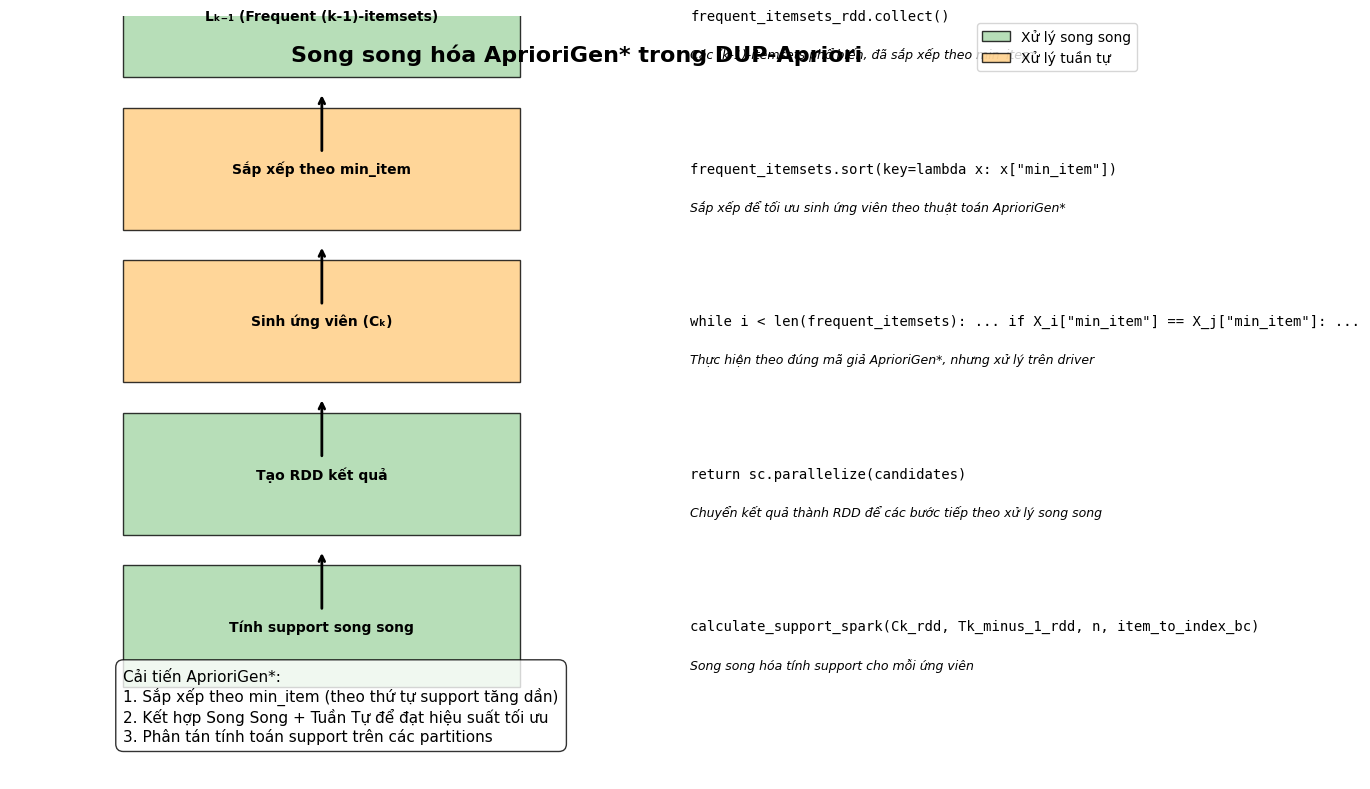

In [10]:
# Minh họa cách AprioriGen* được song song hóa
def visualize_apriorigen_star_parallel():
    # Tạo figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Thiết lập hình ảnh minh họa
    stages = [
        {'name': 'Lₖ₋₁ (Frequent (k-1)-itemsets)', 'parallel': True, 
         'code': 'frequent_itemsets_rdd.collect()', 'desc': 'Các (k-1)-itemsets phổ biến, đã sắp xếp theo min_item'},
        {'name': 'Sắp xếp theo min_item', 'parallel': False, 
         'code': 'frequent_itemsets.sort(key=lambda x: x["min_item"])', 'desc': 'Sắp xếp để tối ưu sinh ứng viên theo thuật toán AprioriGen*'},
        {'name': 'Sinh ứng viên (Cₖ)', 'parallel': False, 
         'code': 'while i < len(frequent_itemsets): ... if X_i["min_item"] == X_j["min_item"]: ...', 'desc': 'Thực hiện theo đúng mã giả AprioriGen*, nhưng xử lý trên driver'},
        {'name': 'Tạo RDD kết quả', 'parallel': True, 
         'code': 'return sc.parallelize(candidates)', 'desc': 'Chuyển kết quả thành RDD để các bước tiếp theo xử lý song song'},
        {'name': 'Tính support song song', 'parallel': True, 
         'code': 'calculate_support_spark(Ck_rdd, Tk_minus_1_rdd, n, item_to_index_bc)', 'desc': 'Song song hóa tính support cho mỗi ứng viên'}
    ]
    
    # Vẽ flowchart
    arrow_props = dict(arrowstyle='->', connectionstyle='arc3', linewidth=2, color='black')
    
    for i, stage in enumerate(stages):
        # Vị trí của node
        y = 1 - i * 0.2
        
        # Màu sắc dựa vào song song hay không
        color = '#A5D6A7' if stage['parallel'] else '#FFCC80'
        
        # Vẽ node
        rect = plt.Rectangle((0.1, y - 0.08), 0.35, 0.16, facecolor=color, alpha=0.8, edgecolor='black')
        ax.add_patch(rect)
        
        # Thêm text
        ax.text(0.275, y, stage['name'], ha='center', va='center', fontweight='bold')
        
        # Thêm mã nguồn và mô tả
        ax.text(0.6, y, stage['code'], fontfamily='monospace', va='center', fontsize=10)
        ax.text(0.6, y - 0.05, stage['desc'], va='center', fontsize=9, style='italic')
        
        # Thêm mũi tên kết nối
        if i < len(stages) - 1:
            ax.annotate('', xy=(0.275, y - 0.1), xytext=(0.275, y - 0.2 + 0.02),
                       arrowprops=arrow_props)
    
    # Tạo legend
    parallel_patch = plt.Rectangle((0, 0), 1, 1, facecolor='#A5D6A7', alpha=0.8, edgecolor='black')
    sequential_patch = plt.Rectangle((0, 0), 1, 1, facecolor='#FFCC80', alpha=0.8, edgecolor='black')
    ax.legend([parallel_patch, sequential_patch], ['Xử lý song song', 'Xử lý tuần tự'], loc='upper right')
    
    # Thêm thông tin bổ sung
    ax.text(0.1, 0.05, 'Cải tiến AprioriGen*:\n'
           '1. Sắp xếp theo min_item (theo thứ tự support tăng dần)\n'
           '2. Kết hợp Song Song + Tuần Tự để đạt hiệu suất tối ưu\n'
           '3. Phân tán tính toán support trên các partitions',
           fontsize=11, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Thêm tiêu đề
    ax.text(0.5, 0.95, 'Song song hóa AprioriGen* trong DUP-Apriori', 
            ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Thiết lập trục
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Vẽ minh họa
visualize_apriorigen_star_parallel()

## Tổng kết về song song hóa thuật toán DUP-Apriori

Phiên bản song song hóa DUP-Apriori trên Spark đã tận dụng hiệu quả các đặc tính của mô hình lập trình phân tán MapReduce thông qua Spark RDDs. Thuật toán đã song song hóa tất cả các phần chính của DUP-Apriori, từ việc đếm tần suất của các items, tiền xử lý giao dịch, tính toán support, cho đến việc lọc các itemsets phổ biến và rút gọn transactions.

### Các cải tiến quan trọng nhất là:

1. **Xử lý giao dịch trùng lặp với trường `dup`**
   - Gom nhóm các giao dịch giống nhau và sử dụng trường `dup` để đếm số lần xuất hiện
   - Cải tiến trọng tâm trong dòng 11: `c.sup += t[i].dup/n`

2. **Sắp xếp items theo support tăng dần và sử dụng min/max để tối ưu hóa**
   - Áp dụng min_item và max_item để lọc nhanh các giao dịch không thể chứa candidate

3. **Tối ưu bộ nhớ và tính toán phân tán**
   - Sử dụng broadcast, cache và unpersist để quản lý bộ nhớ
   - Tự động tối ưu số lượng partitions theo kích thước dữ liệu
   - Checkpointing định kỳ để tránh stack overflow

4. **Cân bằng giữa xử lý tuần tự và song song**
   - Một số phần như AprioriGen* vẫn giữ logic tuần tự để đảm bảo tính chính xác
   - Kết quả được parallelize để các bước tiếp theo xử lý song song

Những cải tiến này giúp thuật toán xử lý hiệu quả các tập dữ liệu lớn phân tán trên các node của cluster Spark, với hiệu suất cải thiện đáng kể khi kích thước dữ liệu tăng.